In [43]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

import dill

rcParams['font.family'] = 'Arial'

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")

In [44]:
with open(DATAFOLDER / "x_array_with_clusters.pickle", "rb") as f:
    x_array = dill.load(f)

In [45]:
x_array

,id,condition,time,infusiontype,cluster
0,PB23,deplete,0,10NaCl,1
1,PB23,deplete,1,10NaCl,3
2,PB23,deplete,2,10NaCl,1
3,PB23,deplete,3,10NaCl,1
4,PB23,deplete,4,10NaCl,3
...,...,...,...,...,...
475,PB75,replete,7,45NaCl,6
476,PB75,replete,8,45NaCl,3
477,PB75,replete,9,45NaCl,3
478,PB75,replete,10,45NaCl,3


In [30]:
with open(DATAFOLDER / "snips_data_selected_conditions_reduced.pickle", "rb") as f:
    data = dill.load(f)

snips_10NaCl = data["snips_10NaCl_reduced"]
snips_45NaCl = data["snips_45NaCl_reduced"]

snips_all = np.vstack([snips_10NaCl, snips_45NaCl])
snips_all.shape

(480, 200)

0 0
Analyzing deplete 10NaCl
(7,)
0 1
Analyzing replete 10NaCl
(7,)
1 0
Analyzing deplete 45NaCl
(7,)
1 1
Analyzing replete 45NaCl
(7,)


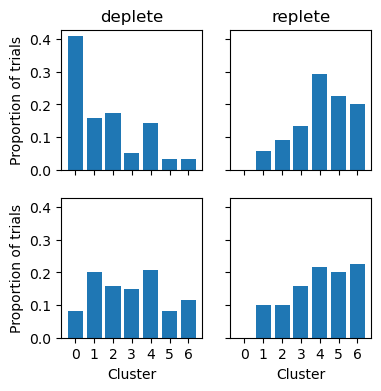

In [4]:
infusiontype = "10NaCl"

df = x_array
n_clusters = len(df.cluster.unique())

f, ax = plt.subplots(ncols=2, nrows=2,
                     figsize=(4, 4),
                     sharey=True, sharex=True)
barx=np.arange(n_clusters)

for row, infusiontype in enumerate(df.infusiontype.unique()):
    for col, condition in enumerate(df.condition.unique()):
        print(row, col)
        print("Analyzing", condition, infusiontype)
        df_temp = df.query("condition == @condition & infusiontype == @infusiontype")
        data_to_plot = (df_temp
                        .groupby("cluster")
                        .count()
                        .reindex(range(0, 7), fill_value=0)  # Ensure clusters 1-7 are present
                        .infusiontype
                        .to_list()
        )
        data_to_plot_as_proportion = data_to_plot / np.sum(data_to_plot)
        print(data_to_plot_as_proportion.shape)
        ax[row,col].bar(barx, data_to_plot_as_proportion)
        # df_condition = df.query("condition == @condition")
        # df_condition = df_condition.sort_values("infusionrate")
        # #plt.plot(df_condition.infusionrate, df_condition.mean, label=condition)
        
    
ax[0,0].set_title("deplete")
ax[0,1].set_title("replete")

for axis in ax[1]:
    axis.set_xticks(barx)
    axis.set_xlabel("Cluster")
    
for axis in [ax[0,0], ax[1,0]]:
    axis.set_ylabel("Proportion of trials")

In [17]:
x_array.groupby(["condition", "infusiontype"]).count()

id  time  cluster
condition infusiontype                    
deplete   10NaCl        120   120      120
          45NaCl        120   120      120
replete   10NaCl        120   120      120
          45NaCl        120   120      120

In [9]:
def get_prop_over_time(df, infusiontype):
    df_temp = df.query("infusiontype == @infusiontype")
    props = []
    for cluster in df_temp.cluster.unique():
        df_cluster = df_temp.query("cluster == @cluster")
        prop = df_cluster.groupby("time").count().id
        props.append(prop)

    return props

p = get_prop_over_time(x_array.query("condition == 'deplete'"), "10NaCl")

In [ ]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(data_for_stats)

# Output the results
print(f"Chi-square statistic: {chi2}")
                     )
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)



Chi-square statistic: 42.497233032866006
P-value: 7.0782284939704e-11
Degrees of freedom: 1
Expected frequencies:
[[333.41300191 131.58699809]
 [ 41.58699809  16.41300191]]


Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6


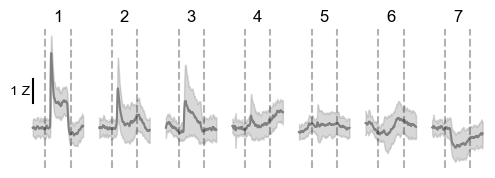

In [75]:
f, ax = plt.subplots(ncols=len(x_array.cluster.unique()), sharey=True, figsize=(6.5, 1.8),
                                          gridspec_kw={'left': 0.2, 'right': 0.9}
                                          )

for cluster in np.arange(0,7):
    print("Cluster", cluster)
    snips_cluster = snips_all[x_array.cluster == cluster, :]
    x = np.arange(snips_cluster.shape[1]) / 10
    mean = np.mean(snips_cluster, axis=0)
    sem = np.std(snips_cluster, axis=0) / np.sqrt(snips_cluster.shape[0])
    sd = np.std(snips_cluster, axis=0)
    
    ax[cluster].plot(x, np.mean(snips_cluster, axis=0), color="grey", lw=1.5)
    ax[cluster].fill_between(x, mean-sd, mean+sd, alpha=0.3, color="grey")
    ax[cluster].set_title(f"{cluster+1}")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.axvline(5, color="k", linestyle="--", alpha=0.3)
    axis.axvline(15, color="k", linestyle="--", alpha=0.3)
    sns.despine(ax=axis, top=True, right=True, left=True, bottom=True)
    

ax[0].plot([0, 0], [1, 2], color="k")
ax[0].text(-1, 1.5, "1 Z", ha="right", va="center", fontsize=10)

#ax[6].plot([5, 15], [-2.5, -2.5], color="k")

f.savefig(RESULTSFOLDER / "snips_clusters.pdf", dpi=600, transparent=True)

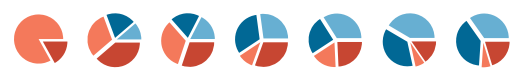

In [ ]:
# order for data is rep_10, rep_45, dep_10, dep_45
 
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

f, ax = plt.subplots(ncols=len(x_array.cluster.unique()), sharey=True, figsize=(6.5, 1),
                     gridspec_kw={'left': [0.2], 'right': [0.9]}
                     )

for cluster in np.arange(0,7):
    tmp = x_array.query("cluster == @cluster")# .groupby(["condition", "infusiontype"]).count().cluster
    total = len(tmp)
    pie_props = [len(tmp.query("condition == 'replete' & infusiontype == '10NaCl'")) / total,
                  len(tmp.query("condition == 'replete' & infusiontype == '45NaCl'")) / total,
                  len(tmp.query("condition == 'deplete' & infusiontype == '10NaCl'")) / total,
                  len(tmp.query("condition == 'deplete' & infusiontype == '45NaCl'")) / total]
    
    ax[cluster].pie(pie_props,
              colors=colors,
              explode=(0.1, 0.1, 0.1, 0.1),
              #autopct='%1.1f%%'
              )

f.savefig(RESULTSFOLDER / "pies_clusters.pdf", dpi=600, transparent=True)


In [13]:
df = x_array

def get_prop_of_cluster(df, cluster, condition, infusiontype):
    df_temp = (df
               .query("condition == @condition & infusiontype == @infusiontype")
               )
               
    prop_by_trial = []

    for trial in df_temp.trial.unique():
        n = len(df_temp.query("trial == @trial"))
        n_cluster = len(df_temp.query("trial == @trial & cluster == @cluster"))
        prop_by_trial.append(n_cluster / n)
    
    return prop_by_trial

p = get_prop_of_cluster(df, 0, "thirsty", "45NaCl")

AttributeError: 'DataFrame' object has no attribute 'trial'

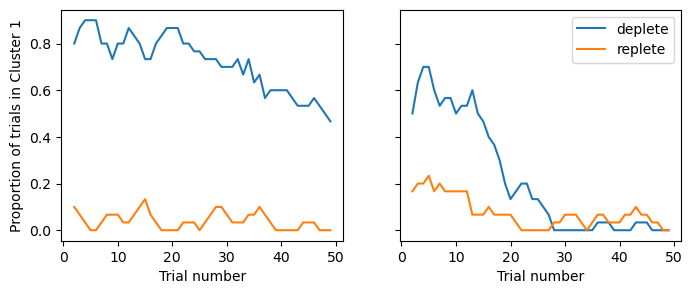

In [10]:
df = x_array

f, ax = plt.subplots(ncols=2, figsize=(8, 3), sharey=True)

cluster=0

infusiontype = "10NaCl"
for condition in df.condition.unique():
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[0].plot(df_to_plot.rolling, label=f"{condition} cluster {cluster}")
        
infusiontype = "45NaCl"
for condition in df.condition.unique():
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[1].plot(df_to_plot.rolling, label=condition)
        
ax[1].legend()

ax[0].set_ylabel("Proportion of trials in Cluster 1")

for axis in ax:
        axis.set_xlabel("Trial number")
        #axis.set_ylim(0, 1)